# Polytech' Nice Data Science course 2021
# Plant Classification

Students:
- Titouan Le Mao (SI5 SD)
- Julien Raige-Verger (SI5 SD)

Team Name:
Boostiflor

**Imports**

In [ ]:
#Import Pytorch
import torch
import torchvision
from torchvision import transforms
from torchvision import models

#Import EfficientNet (the model we use is from EfficientNet)
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet


#Little commonly used shortcut
import torch.nn as nn

#We need the display function from IPython for Jupyter Notebook/Colab
from IPython.display import display

#A package to make beautiful progress bars :) 
from tqdm.notebook import tqdm

import cv2
import glob

# data augmentation library
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import random
from PIL import Image
import numpy as np
from numpy import asarray

import csv
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os

# a little helper function do directly display a Tensor
def display_tensor(t):
  trans = transforms.ToPILImage()
  display(trans(t))

# **DATA**

In this part, we will do our data exploration, by taking a first look at our dataset, possibly perform data augmentation, and create our different sets (training, validation and testing).

In [ ]:
ds = torchvision.datasets.ImageFolder("../input/polytech-nice-data-science-course-2021/polytech/train")

In [ ]:
print(ds)

We can see that our base training dataset is composed of 126 141 plant images. We also know that our dataset is composed of 153 different plant classes.<br>
Before diving too deep into our data, let us take a first look by displaying some random images inside it, along with their respective class number.

In [ ]:
display(ds[0][0])
display(ds[0][1])

display(ds[120][0])
display(ds[120][1])

display(ds[5900][0])
display(ds[5900][1])

display(ds[69900][0])
display(ds[69900][1])

We notice that some images have different sizes, so we will need to resize the images on the fly a bit later. For now, let's just keep it in mind. <br>
Let us now take a look at some images from the same class.

In [ ]:
i = 0
class_10_images = []
for x in ds:
    if x[1]==10:
        class_10_images.append(x[0])
        i = i+1
    if i == 3:
        break

for j in range(len(class_10_images)):
    display(class_10_images[j])

From those specific images, we notice that we can have images of the same plant species where the plant is blooming (and thus creating flowers) and where the plant is not blooming (only leaves). This might be hard for our model to recognize both of these configurations (blooming and not blooming) as the same plant, but we will see that later.

Now that we had a first look at our data, let us do some data exploration, by making sure that our dataset is balanced (does each class have a similar number of samples ?). This might take some time since we have more than 150k images.

In [ ]:
#Get only the label for each image as a list
labels = [x[1] for x in ds]

#Use the "count" method from Python lists
for x in range(153):
  print("Number of", x, ":", labels.count(x), "\n")

We notice that our dataset is heavily imbalanced, with some classes being way over-represented compared to other classes (some having around 5000 samples and others less than 100). 

Thus this bad balance of images has a direct impact on our results since the classes with few images are not well trained and therefore are poorly predicted in most cases. 

In order to solve this problem and to improve our accuracy on the predictions of the test images, we decided to perform a Data Augmentation on our dataset. 

This technique allowed us to generate new images from the basic one and thus to increase the number of training images for each class. 



At first we chose to apply the data augmentation only on the classes with less than 1000 images in order to make the training dataset more balanced. Unfortunately, the results obtained were not convincing. Indeed, we obtained excellent results on the Training and Validation part (>0.90) but not on the tests. This can be explained by the fact that we had unintentionally added details to the images (such as variations in brightness, contrast or the way they are framed) that allowed us to differentiate the classes with less than 1000 images from those with many images. But obviously, on the test images these differentiations were not present and therefore the results were not as good.

Therefore, after different tests we observed that the best results were obtained by applying the data augmentation on the whole dataset. We applied different transformations on the images without changing their nature too much in order to keep a coherent dataset. RandomCrop allowed us to crop the images randomly in order to generate a lot of images while still keeping the important information.

In [ ]:
class AugmentationDataset(torch.utils.data.Dataset):
  
  def __init__(self, img_dir):
    
    super().__init__()
    
    # store directory names
    self.img_dir = img_dir

    # use glob to get all image names
    self.img_names = [(x.split("/")[6],x.split("/")[5]) for x in glob.glob(img_dir + "/*/*")]
    
    

  def __len__(self):
    return len(self.img_names)
    
  def __getitem__(self,i):
    return self._read_img(i)
  
  def _read_img(self, i):
    img = Image.open(self.img_dir + "/" + self.img_names[i][1] + "/" + self.img_names[i][0])
    #img = cv2.imread(self.img_dir + "/" + self.img_names[i][1] + "/" + self.img_names[i][0], cv2.IMREAD_COLOR)
    w, h =img.size
    w = int(w-(w/3))
    h = int(h-(h/3))
    transform = A.Compose([
                                A.HorizontalFlip(p=0.5), 
                                A.VerticalFlip(p=0.5),
                                A.RandomCrop(width=w, height=h),
                                A.Resize(365,365),
                                ToTensorV2()])
    return transform(image=asarray(img), label=int(self.img_names[i][1])-1)

We can see below some examples of transformations for the same image.

In [ ]:
plant_data = AugmentationDataset("../input/polytech-nice-data-science-course-2021/polytech/train")
print("Number of images in dataset:", len(plant_data))
print(plant_data)

sample = plant_data[13101]
print(sample["label"])
display_tensor(sample["image"]) 

sample = plant_data[13101]
display_tensor(sample["image"])
sample = plant_data[13101]
display_tensor(sample["image"]) 
sample = plant_data[13101]
display_tensor(sample["image"]) 
sample = plant_data[13101]
display_tensor(sample["image"]) 

About the batch size, we decided to initialize it to 32 since it was the best compromise between performance and training time of the dataset.

In [ ]:
BATCH_SIZE = 32

## Percentage of validation data
validation_split = 0.1

N_val_samples = round(validation_split * len(plant_data))

## Split into two Subset
cd_train_set, cd_val_set = torch.utils.data.random_split(plant_data, [len(plant_data) - N_val_samples, N_val_samples])

cd_train_dl = torch.utils.data.DataLoader(cd_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

cd_val_dl = torch.utils.data.DataLoader(cd_val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# **NETWORK**

After testing different models described in detail in the "PROGRESS" section we chose to use the pre-trained EfficientNetB3 model since it proved to be the most accurate for our case. We found it by doing some research on the net. Indeed, the EfficientNetB type of model is very efficient for image classification. There are 8 of them from EfficientNetB0 to EfficientNetB7 and they are more and more efficient. As in our case we were constrained to a maximum time of 9 hours for the GPU and a maximum memory of 16GB, the B3 proved to be the most suitable. It allows to make enough epochs to train the model correctly without overfitting.

In [ ]:
# We only have 153 classes, so we need to specify in in the model parameters.
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=153)

We decided to use cross entropy loss because it minimizes the distance between two probability distributions, in our case the predicted and the real one. What's more, since we are dealing with a multi-class image classification, cross entropy is good, because we want our model to target the real class for an image given as input as much as possible (score close to 1), while having scores close to 0 for the other classes (which is exactly like the real probability distribution).

About the optimizer, we concluded by different experiments that the Adam was simpler and more appropriate to our problem since it automatically adapts the learning rate and the momentum. Contrary to the SGD optimizer which requires to set these parameters manually which requires more control and testing.


In [ ]:
LEARNING_RATE = 0.001

## Move model to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

# **TRAINING**

For training our model, we use a classical training and validation loop. At the last epoch, we retrieve the predictions made on the validation data and their labels in order to display the confusion matrix.

In [ ]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 10

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
preds, y_test = np.array([]), np.array([])

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(tqdm(cd_train_dl)):
    
    # Get a batch from the dataloader
    x = batch["image"].float()
    labels = batch["label"]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Training accuracy:", running_accuracy/float(len(cd_train_set)),
        "Training loss:", running_loss/float(len(cd_train_set)))
  
  epoch_loss.append(running_loss/len(cd_train_set))
  epoch_acc.append(running_accuracy/len(cd_train_set))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  
  for i, batch in enumerate(tqdm(cd_val_dl)):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch["image"].float()
      labels = batch["label"]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y = net(x)
      
      # Compute the loss
      loss = criterion(y, labels)
      
      if e == 9:     
          preds = np.hstack([preds, y.max(1)[1].cpu().numpy()])
          y_test = np.hstack([y_test, labels.cpu().numpy()])
    
      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Validation accuracy:", running_val_accuracy/float(len(cd_val_set)),
        "Validation loss:", running_val_loss/float(len(cd_val_set)))
  
  epoch_val_loss.append(running_val_loss/len(cd_val_set))
  epoch_val_acc.append(running_val_accuracy/len(cd_val_set))
      

# **EXPERIMENTS**

In [ ]:
classes = [0]*153
for i in range(0,153):
    classes[i] = i+1

Here we display the confusion matrix in order to identify the classes that are poorly predicted. As can be seen here, classes 1,4,30, 31, 33, 35, 45, 58, 59, 61, 71, 78, 81, 89, 90, 97, 101, 106, 112, 121, 124, 130, 132, 136, 137 and 145 have predictions below 50%. When we pay attention to their number of training images, we see that most of them have less than 100 images. Thus, these results are logical since these classes are less well trained than the others. 

In [ ]:
def show_confusion_matrix(pred, Y_TEST, classes):

  cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
  cm = normalize(cm,axis=1,norm='l1')
  
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  
  plt.figure(figsize=(120,70))
  
  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(df_cm, annot=True,cmap=cmap)
  plt.title('Confusion Matrix',fontdict={'fontsize':20})
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show


show_confusion_matrix(preds, y_test, classes)

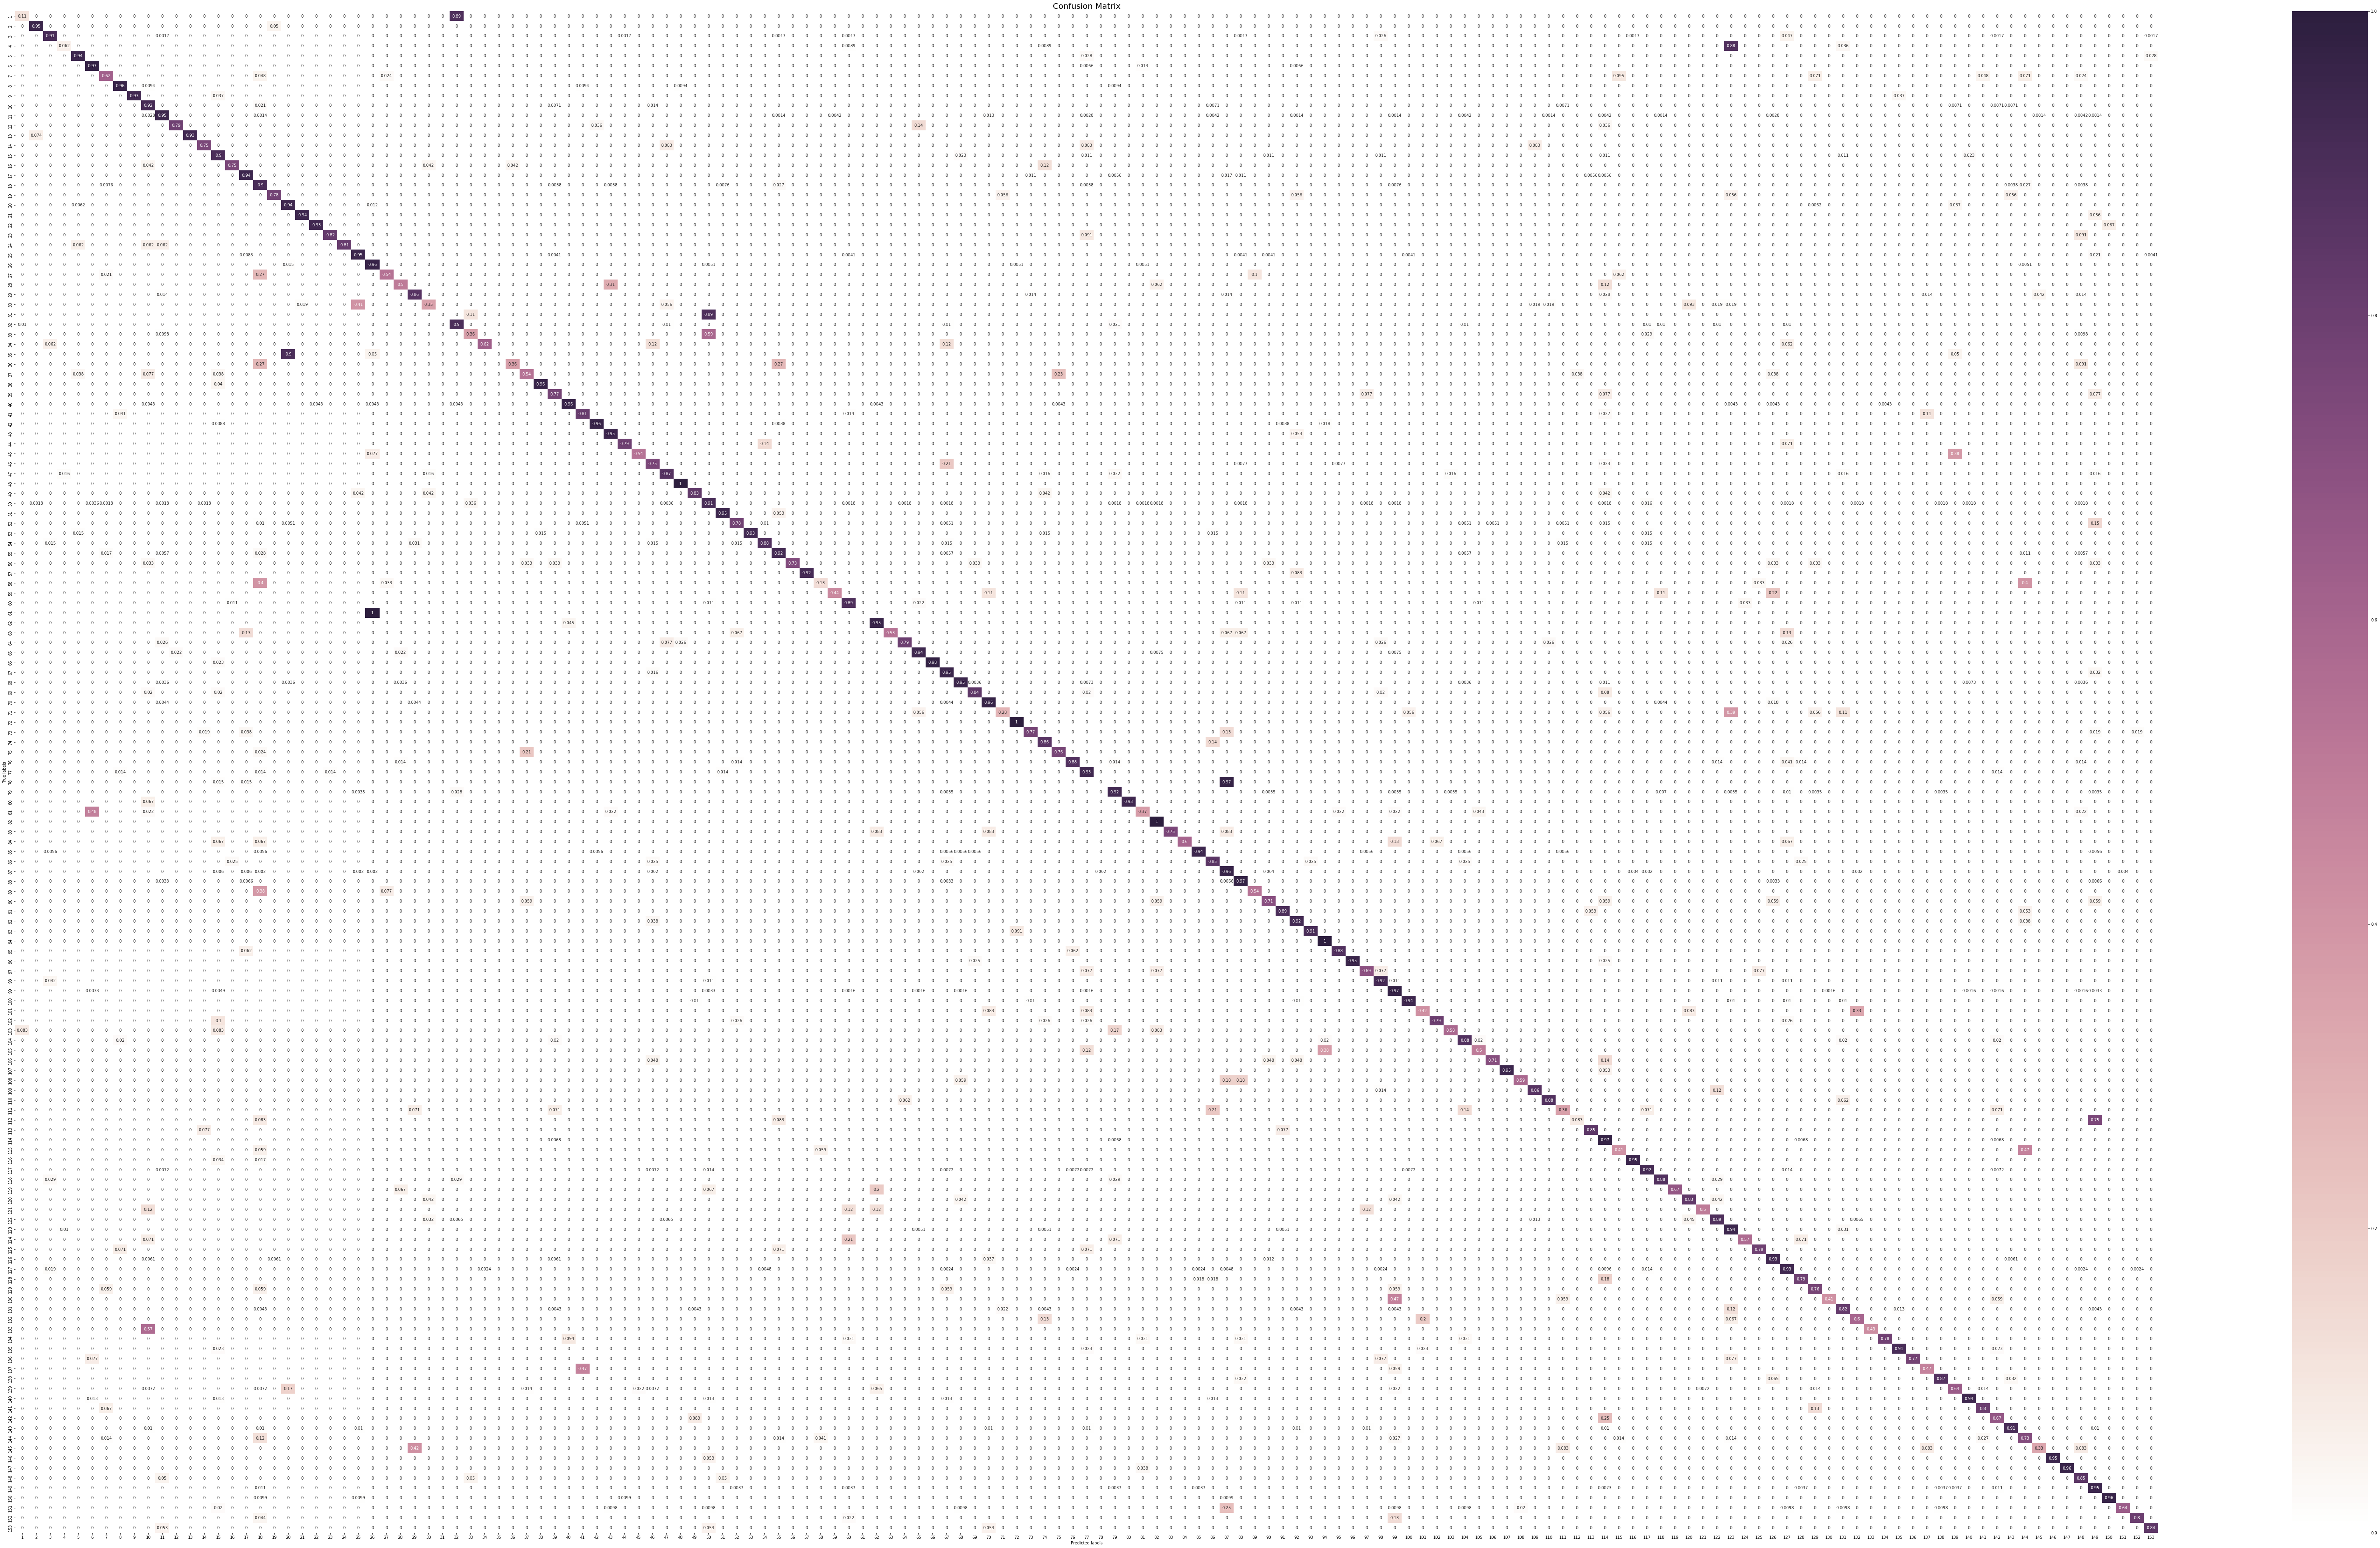

Moreover, we notice that some of them are confused almost 90% of the time with another class. And when we look in detail, we can clearly see that the 2 types of flowers are very similar. So, that's why less well trained classes with similarities with other better trained classes of the dataset are often confused. 

Unfortunately, even by applying data augmentation and modifying the model weights we were not able to solve this problem.

Once the model is trained we make a prediction on each image of the test dataset and store it in a dictionary having for key the name of the image and in value the associated prediction having the highest score.


In [ ]:
convert = A.Compose([A.Resize(365,365), ToTensorV2()])
names = glob.glob("../input/polytech-nice-data-science-course-2021/polytech/test/*")

#We sort the name of images by number
names = sorted(names, key=lambda s: int(s[62:-4]))

result={}
for n in tqdm(names):
  img = Image.open(n)
  t = convert(image=asarray(img))
  
  y = net(t["image"].float().unsqueeze(0).cuda()).max(1)[1]
  
  plantType = y[0].cpu().detach().numpy()
  n = n.replace("../input/polytech-nice-data-science-course-2021/polytech/test/", '')
  result[n] = plantType+1

We display here some examples of predictions on the test dataset images that our trained model has made.

In [ ]:
path = "../input/polytech-nice-data-science-course-2021/polytech/test/"
i=0
for key, value in result.items():
    testImg = Image.open(path + key)
    t = convert(image=asarray(testImg))
    display_tensor(t["image"])
    print("Prediction : Class ", value, "\n")
    i+=1
    if i == 5:
        break

 Once the test dataset is browsed we generate our submission file by browsing the result dictionary.

In [ ]:
a_file = open("submission.csv", "w")

writer = csv.writer(a_file)
header = ["image_name", "class"]
writer.writerow(header)
for key, value in result.items():
    writer.writerow([key, value])

a_file.close()

# **PROGRESS**

This section will focus on trying to explain how we got to our final accuracy (which technical choices led to which improvements in terms of accuracy/efficiency). <br><br>
It will be separated into several parts, each part corresponding to a model that we have tested and used with multiple configurations (by modifying the number of epochs, the batch size, the size of the images considered, with different methods such as weighted loss, data augmentation) <br> <br>

Then, we will try to make a summary explaining which methods have been the most effective.

# ResNet

The first model we used was the ResNet18 model since we were inspired by the labs done in class to create the structure of our notebook.
We tried multiple configurations and managed to get a score of **0.72665** (which was our best score at the time). The corresponding configuration was:
- Model: ResNet18
- Number of Epochs : 6
- Batch Size : 64
- Image Size : 199x199

Then, we noticed a certain stagnation (or loss sometimes) in the scores when we varied the configurations, so we decided to try **ResNet50**, which has, as its name indicates, 50 layers instead of the 18 layers of ResNet18. <br>
Thanks to ResNet50, we managed to get a score of **0.77114**, which was a considerable improvement over our previous best score. On top of changing the model from ResNet18 to ResNet50, we also chose to start using a **350x350** size for images, which was a lot bigger than before. Because we used a model with more layers and bigger images, we had to reduce our **batch size to 32** for memory issues. It is important to note that despite ResNet50 giving a better score for our data, it also came with a cost, which was the run time (which was longer than ResNet18). <br> <br>

This is as far as we managed to get with ResNet without altering our base data.<br> In the next part, we will explain how we tried to implement weights associated to each class to try and reduce the effect of the imbalance of the dataset. 

<br> <br>
summary:
1. ResNet18 | 6 Epochs | Batch Size 64                  --> 0.72665
1. ResNet50 | Batch 32                                  --> 0.76406
1. ResNet50 | 10 Epochs | Batch 32 | Image Size 350x350 --> 0.77114

# ResNet with weighted loss

After reaching a score of 0.77, which we already considered a pretty good score, we decided to start working more on our data rather than look for a new, even better model.
<br><br>
Thanks to our data exploration, we already had a good idea of what could improve our model: counterbalancing the fact that our plant classes are not balanced (that there is not a more or less equal number of image samples for each class).
<br><br>
To do so, we had multiple ideas. Initially, we wanted to try undersampling the over representated classes and oversampling the underly representated classes. But we were not really convinced by that idea because it would mean throwing away samples from the overly representated classes, which is kind of a waste of data. So instead, and thanks to the help of our teacher, we tried to apply weights to each class. 
<br><br>
The way we tried to make it work was to apply a bigger weight to classes that did not have a lot of samples and a smaller weight to classes that had a lot of samples, so that our model would consider more our underly representated classes.
<br><br>
To do so, we calculated the weight of a class by dividing the total number of images in our whole training dataset (~150k) by the number of images in our current class. This way, the bigger the number of images in our current class is, the smaller our division becomes, and thus the smaller the weight becomes. We tried to train our model with this weighted loss method, thinking it would bring us good results, but we got a score of **0.64092** when using it with ResNet18 with 15 epochs. We thought that it might be an hyper-parameter problem and tried multiple configurations, but we never managed to get a score **beyond 0.70**, which was both a surprise and a disappointment for us.
<br> <br>
When we looked at the confusion matrix, we noticed that because of our weighted loss, we DID manage to recognize in a better way the classes that were not well recognized before (without a lot of sample images), BUT that came with a heavy cost, which was that we started to perform worse than before on classes that had a lot of images, which was the reason our score dropped so much.
<br> <br>
We had to find another idea that would allow us to perform well on small classes without performing too badly on big classes.


<br> <br>
summary:
- ResNet18 Weighted Loss | 15 Epochs                   --> 0.64092

- ResNet18 Weighted Loss --> Never beyond 0.70

# ResNet with data augmentation

We already thought of performing data augmentation initially, but we did not do it because we thought that it would not be efficient since we only wanted to upsample some of our classes, and not our whole dataset. While looking for a new idea, we decided to give data augmentation on our whole dataset a try, and see how it would perform. By using **data augmentation** with **ResNet50** on **16 epochs**, and with a **batch size equal to 32**, we managed to get a score of **0.80855**, our highest score at the time, and also the first time we passed the 0.80 cap. We were a bit confused because we did not think it would perform that well since the ratio between small classes and big classes would remain the same, but in the end we said to ourselves that this score increase was due to the fact that even if the ratio was the same; simply creating (artificially) new images for our small classes was enough for the model to perform better.


<br><br>
summary:
- Resnet50 / 16E / DataAugmentation / Batch 32         --> 0.80855


# EfficientNet

First of all, here is a link leading to a paper explaining what EfficientNet is. https://paperswithcode.com/method/efficientnet <br> <br>
EfficientNet is a family of CNN models created to perform image classification and achieve state-of-the-art results while being faster than other models. <br> <br> The initial model of the EfficientNet family is called EfficientNetB0, and is based on AutoML MNAS Mobile framework. All the other models from the EfficientNet family are created from B0 thanks to compound scaling. <br> <br>
Here is a benchmark comparing EfficientNets with other models. <br>
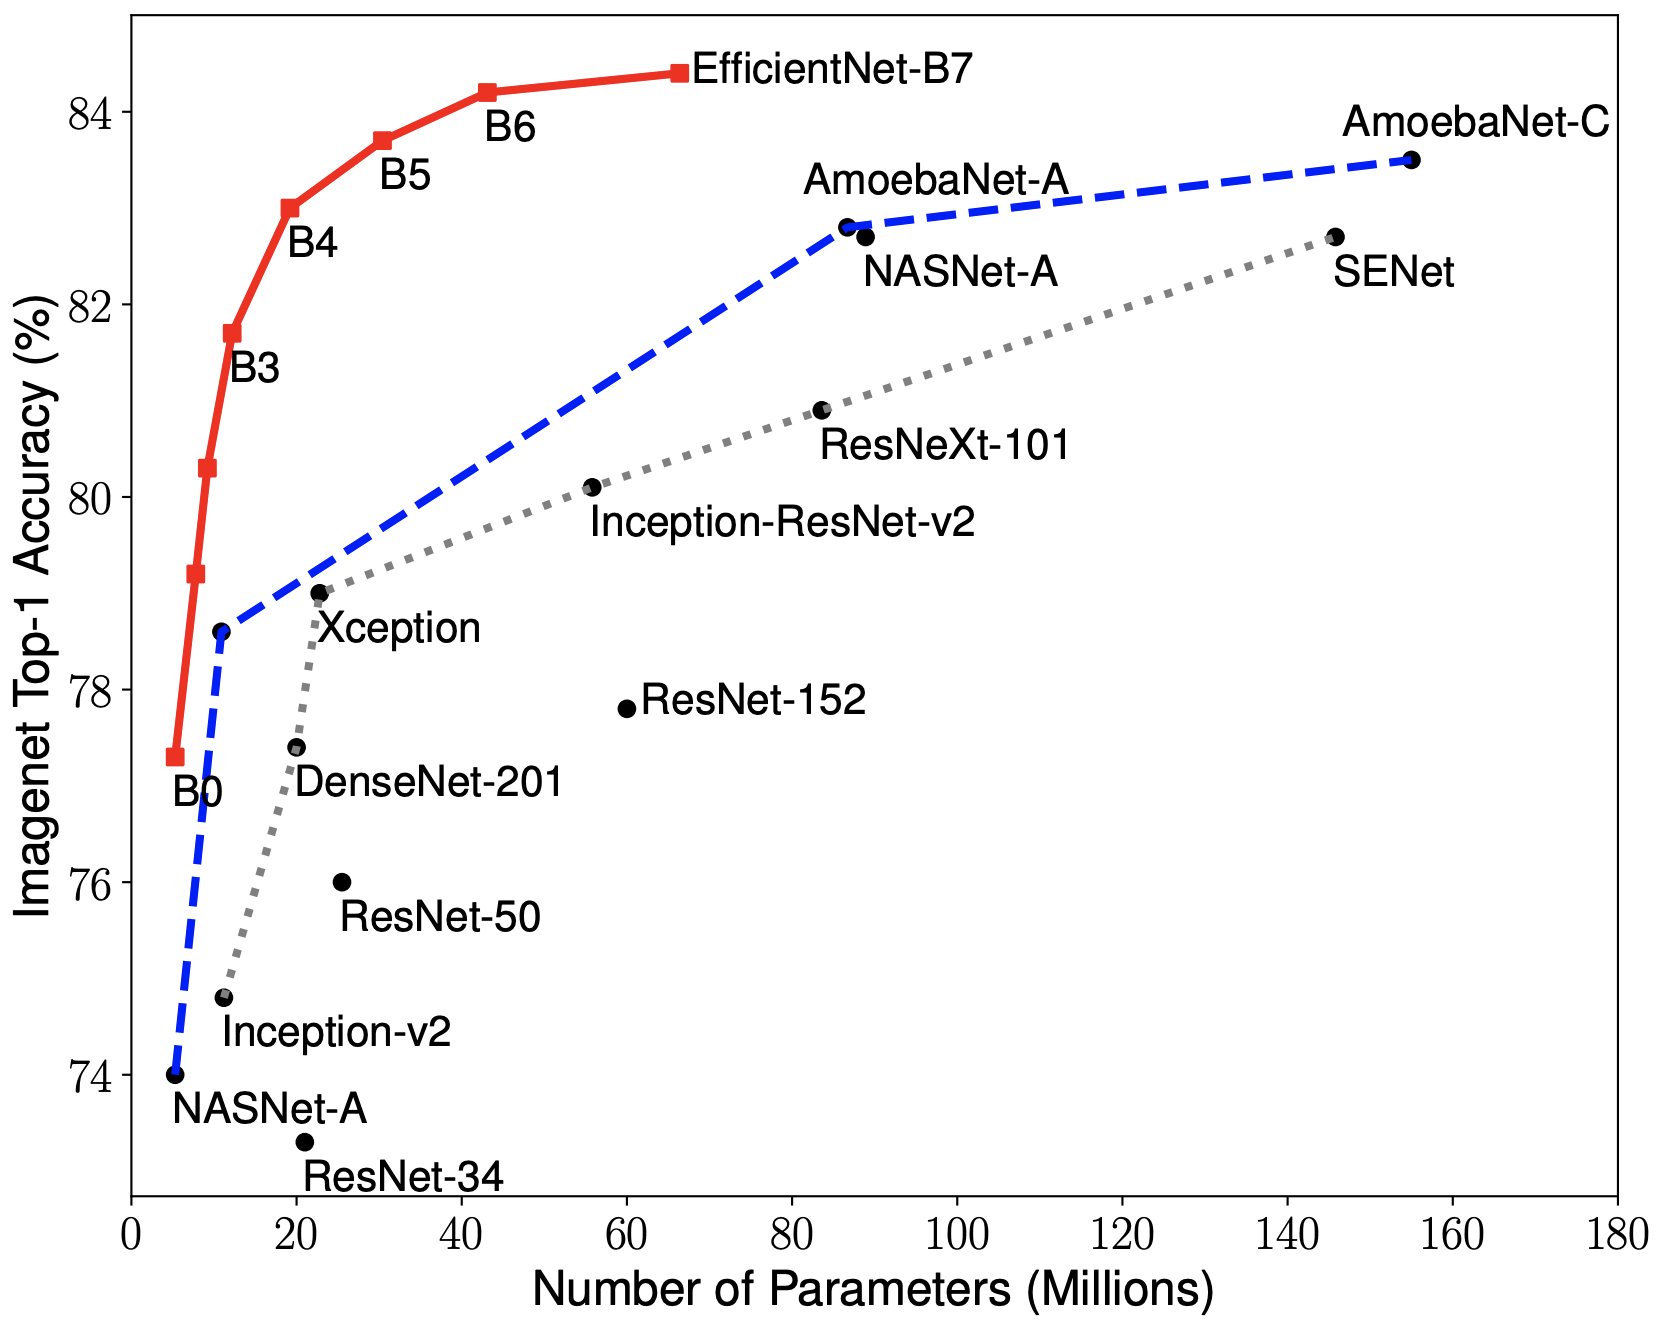

After working with ResNet for a while, we chose to experiment with some new models. We chose to give some EfficientNet models a try based on benchmarks and documentation we found online. We first tried **EfficientNet_B0**, with some random hyper parameters, and were shocked by how good the model was performing right after the first epoch. We managed to get an accuracy of **0.82811** with **EfficientNetB0** on our first try, and we immediately wanted to try other models fom the EfficientNet architecture. We worked with **EfficientNetB2** for a while and managed to get an accuracy of  **0.84072** with the following configuration: 6 epochs, batch size 32, image size 299x299. <br> <br>

At this time, we were kind of satisfied with our results and our accuracy, so we decided to stick with B2 for a while and experiment on it, using Data Augmentation and  methods that we previously tried but which did not work, such as weighted loss. We once again did not manage to make it work (by making it work we mean getting better results than without it) and just kept our previous configuration, with simple data augmentation. <br> <br>

We gave **EfficientNetB7** a try but it did not perform well and was very slow since there are more and more parameters as we advance through EfficientNet models. <br>
We also tried to implement data augmentation only on classes with a small number of images (<1000) but it did not bring astonishing results. <br><br>

We finally settled on **EfficientNetB3** because we found it to be the best compromise between run time and performance, as we managed to get an accuracy score of **0.86113**, which was our highest for quite some time, before managing to get our final best accuracy score of **0.86920** by increasing the images size (which also came with a longer runtime obviously) with the following configuration: 9 Epochs, Batch Size 32, Image Size 365x365. The main challenge here was to find a reasonable image size (not too small) without having to reduce the batch size too much, because it would mean drastically increasing the runtime of our code.
<br> <br>

summary:
- EfficientNet B0 Vanilla                              --> 0.82811 |||||| **5th**
- EfficientNet B2 | 6 Epochs | Batch 32 | Image 299x299--> 0.84072 |||||| **4th**
- EfficientNet B7 | 6 Epochs | Batch 16 |              --> 0.78857
- EfficientNet B3 | 10 Epochs | Batch 32 | Image 350x350--> 0.86113 |||||| **2nd** 

- EfficientNet B3 DataAug on small classes (brightness..)--> 0.74904
- EfficientNetB3 DataAug on small classes (no bright)| 9 Epochs | --> 0.84866 |||||| **3rd**

- EfficientNet B3 | 10 Epochs | Batch 32 | Image 365x365--> 0.86920 |||||| **1st** 


# **CONCLUSION**

During this kaggle challenge we were able to experiment with several useful data science techniques and discover new ones. We were confronted with a recurrent problem which is the unbalanced training dataset. Unfortunately, we did not manage to completely solve this problem but the different investigations we did to solve it were very interesting and enriching.


A suggestion for future work would have been to further investigate data augmentation, with for example TTA, in order to find the perfect balance allowing a better prediction of underrepresented classes. Moreover, even if the GPU time limit is quite restrictive, it would be interesting to test model ensembling for this problem to see if it allows to obtain better results.